## Import libraries

In [18]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import random

## Download and Preprocess Dataset

In [19]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

In [20]:
batch_size = 64
epochs = 30
num_classes = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

## Preprocessing

In [21]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [22]:
def generate_labels(dataset_images,image_type):
  labels = np.full(shape=(dataset_images.shape[0]),fill_value=[image_type])
  return labels

# function for adding salt
def put_salt(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    # np.random.shuffle(image_indices)
    # image_indices = image_indices[:image_indices.shape[0] // 5 + 1]
    original_images = source_dataset_images[image_indices] # get the original images
    negative_images = invert(original_images)
    for i in range(len(original_images)):
      flattened_image = original_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.4:
          flattened_image[j] = 1
      original_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,original_images))
    for i in range(len(negative_images)):
      flattened_image = negative_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.2:
          flattened_image[j] = 1
      negative_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,negative_images))
    return target_dataset

# function for adding pepper
def put_pepper(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    # np.random.shuffle(image_indices)
    # image_indices = image_indices[:image_indices.shape[0] // 5 + 1]
    original_images = source_dataset_images[image_indices] # get the original images
    negative_images = invert(original_images)
    for i in range(len(original_images)):
      flattened_image = original_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.6:
          flattened_image[j] = 0
      original_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,original_images))
    for i in range(len(negative_images)):
      flattened_image = negative_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.8:
          flattened_image[j] = 0
      negative_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,negative_images))
    return target_dataset

# function for inverting data
def get_inverted_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    # np.random.shuffle(image_indices)
    # image_indices = image_indices[:image_indices.shape[0] // 5 + 1]
    original_images = invert(source_dataset_images[image_indices]) # get the original images and invert them
    target_dataset = np.concatenate((target_dataset,original_images))
    return target_dataset

# add some data from already available negative data
def add_negative_data(source_dataset_images,source_dataset_labels,target_dataset,class_num,amount):
  image_indices = np.asarray(np.where(source_dataset_labels != class_num))
  image_indices = image_indices.flatten()
  np.random.shuffle(image_indices)
  image_indices = image_indices[:amount] # take very less amount of negative data

  original_images = source_dataset_images[image_indices]
  target_dataset = np.concatenate((target_dataset,original_images))
  inverted_images = invert(original_images)
  target_dataset = np.concatenate((target_dataset,inverted_images))
  salt_images = np.concatenate((np.copy(inverted_images),np.copy(original_images)))
  pepper_images = np.concatenate((np.copy(inverted_images),np.copy(original_images)))
  for i in range(len(salt_images)):
    flattened_image = salt_images[i].flatten()
    for j in range(len(flattened_image)):
      p = random.uniform(0,1)
      if p <= 0.6:
        flattened_image[j] = 0
    salt_images[i] = np.reshape(flattened_image,(28,28))
  target_dataset = np.concatenate((target_dataset,salt_images))
  for i in range(len(pepper_images)):
    flattened_image = pepper_images[i].flatten()
    for j in range(len(flattened_image)):
      p = random.uniform(0,1)
      if p <= 0.8:
        flattened_image[j] = 1
    pepper_images[i] = np.reshape(flattened_image,(28,28))
  target_dataset = np.concatenate((target_dataset,pepper_images))
  return target_dataset

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num,amount):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
    # print(f"Positive train data shape: {dataset_images_positive.shape}")
    # get the images for making negative dataset
    dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    dataset_images_negative = put_salt(dataset_images,dataset_labels,dataset_images_negative,class_num)
    # print(f"Negative train data shape: {dataset_images_negative.shape}")
    dataset_images_negative = put_pepper(dataset_images,dataset_labels,dataset_images_negative,class_num)
    # print(f"Negative train data shape: {dataset_images_negative.shape}")
    dataset_images_negative = get_inverted_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    # print(f"Negative train data shape: {dataset_images_negative.shape}")
    dataset_images_negative = add_negative_data(dataset_images,dataset_labels,dataset_images_negative,class_num,amount)
    # print(f"Negative train data shape: {dataset_images_negative.shape}")
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y.to(torch.int64))
    return new_dataset

def prepare_testing_data(dataset_images,dataset_labels,class_num):
  positive_indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
  positive_indices = positive_indices.flatten()
  # get the images for making positive dataset
  dataset_images_positive = dataset_images[positive_indices] # images consisting of positive class
  dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
  # print(f"Positive test data shape: {dataset_images_positive.shape}")
  # get the images for making negative classes for testing
  negative_indices = np.asarray(np.where(((dataset_labels != class_num))))
  negative_indices = negative_indices.flatten()
  # negative_indices = negative_indices[:1000]
  # get the images for making negative dataset
  dataset_images_negative = dataset_images[negative_indices]
  dataset_labels_negative = generate_labels(dataset_images_negative,1)
  # print(f"Negative test data shape: {dataset_images_negative.shape}")
  # concatenate the negative and positive datasets
  modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
  modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
  tensor_x = torch.Tensor(modified_dataset_images)
  tensor_y = torch.Tensor(modified_dataset_labels)
  new_dataset = TensorDataset(tensor_x,tensor_y.to(torch.int64))
  return new_dataset

### Plotting the data

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0])


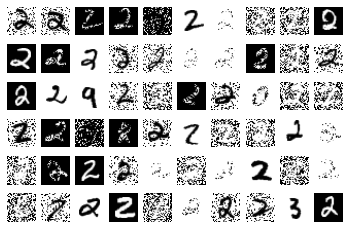

In [23]:
class_num = 2
amount = 600
train_class_set = prepare_training_data(train_images,train_labels,class_num,amount) # fetch the training set for a class
test_class_set = prepare_testing_data(test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
  # if labels[index] == 0:
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')
    # break

## Build the neural network

In [24]:
# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16*4*4, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training the model

In [25]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.5)
  # train the model
  model = model.to(device)
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for batch, (images,scores) in enumerate(train_loader):
      (images,scores) = (images.to(device),scores.to(device))
      optimizer.zero_grad()
      # compute prediction error
      output = model(images)
      loss = criterion(output,scores)
      # Backpropagation
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    # else:
    #   print(f"Training loss: {running_loss/len(train_loader)}")
  return model

### Testing the model

In [38]:
def test(model,testloader,classes,thresh,failed_points=None,passed_points=None,scores=None):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)
  model = model.to(device)
  y_true = []
  y_proba = []
  y_pred = []
  with torch.no_grad():
    for images,labels in testloader:
      (images,labels) = (images.to(device),labels.to(device))
      output = F.softmax(model(images),dim=1)
      for i in range(len(labels)):
        y_true.append(labels[i].cpu())
        yes_score = output[i][0].item()
        no_score = output[i][1].item()
        y_proba.append(yes_score)
        pred = 0 if output[i][0] >= thresh else 1
        y_pred.append(pred)
        if labels[i] == 0:
          scores = np.vstack((scores,[[yes_score,no_score,labels[i].cpu()]]))

        correct[labels[i]] += (pred == labels[i])
        total[labels[i]] += 1
        if pred != labels[i] and labels[i] == 0 and yes_score < no_score:
          failed_points.append(images[i])
        # if pred == labels[i] and labels[i] == 1:
        #   passed_points.append(images[i])
  print(f"Accuracy : {np.sum(correct) / np.sum(total)}")
  # auc = roc_auc_score(y_true,y_proba)
  fpr,tpr,_ = roc_curve(y_true,y_proba,pos_label=0)
  precision = precision_score(y_true,y_pred,pos_label=0)
  recall = recall_score(y_true,y_pred,pos_label=0)
  f1 = f1_score(y_true,y_pred,pos_label=0)

  return {'scores': scores,'correct':correct,'total':total,'fpr': fpr,'tpr': tpr,'precision':precision,'recall':recall,'f1':f1}

### Train the model

In [27]:
model = NeuralNetwork()
model = train(model,train_loader)

### Making predictions from the model

Number of points for class 2: 600
[0.5 0.6 0.7 0.8 0.9 1. ]
Accuracy : 0.8556
[ 974. 7582.] [1032. 8968.]
Precision: 0.41271186440677965
Recall: 0.9437984496124031
F1 score: 0.5742924528301887


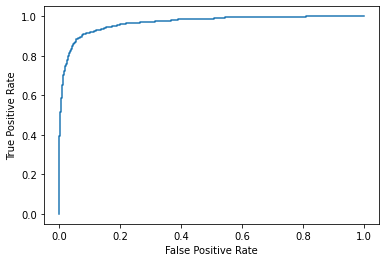

In [40]:
# amount = 1000
# class_num = 5
# for class_num in range(num_classes):
failed_points = []
passed_points = []
average = 0
print(f"Number of points for class {class_num}: {amount}")
x = np.linspace(0.5,1,6)
print(x)
scores = np.empty((0,3),dtype=np.float32)
thresh = 0.6

# for thresh in x:
  # train_class_set = prepare_training_data(train_images,train_labels,class_num,amount) # fetch the training set for a class
  # test_class_set = prepare_testing_data(test_images,test_labels,class_num)
  # train_loader = DataLoader(train_class_set,batch_size=batch_size,shuffle=True)
  # test_loader = DataLoader(test_class_set,batch_size=batch_size,shuffle=True) # take original testing set of all classes
metrics = test(model,test_loader,2,thresh,failed_points=failed_points,scores=scores)
print(metrics['correct'],metrics['total'])
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")
print(f"F1 score: {metrics['f1']}")
scores = metrics['scores']
average += (metrics['correct'][0] + metrics['correct'][1]) / (metrics['total'][0] + metrics['total'][1])
# print(f"AUC score: {accuracies[3]}")
# print(f"Average accuracy: {average / (len(x))}")
df = pd.DataFrame(scores)
df.columns = ['yes_score','no_score','true_label']
df.describe()
plt.plot(metrics['fpr'],metrics['tpr'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Plot Yes score/ No score plot

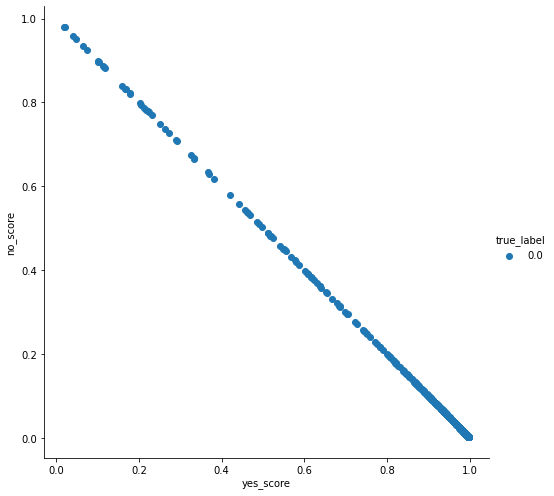

In [32]:
sns.FacetGrid(df,hue="true_label",height=7).map(plt.scatter,"yes_score","no_score").add_legend()
plt.show()

### Plot failed data points

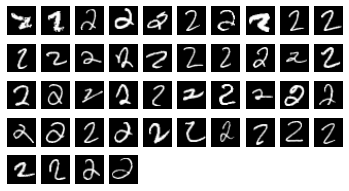

In [33]:
for index in range(0,min(60,len(failed_points))):
# index = 1
  plt.subplot(6,10,index+1)
  plt.axis('off')
  plt.imshow(failed_points[index].cpu().squeeze(),cmap='gray_r')

### Plot passed data points

In [31]:
# for index in range(1,61):
# # index = 1
#   plt.subplot(6,10,index)
#   plt.axis('off')
#   plt.imshow(passed_points[index].cpu().squeeze(),cmap='gray_r')